# RQTL Prompt Classification - Examples of how to classify prompts by Request vs Question

In [5]:
from transformers import pipeline, AutoTokenizer, TFAutoModelForSequenceClassification, TFTrainingArguments, AdamWeightDecay
from IPython.display import clear_output
from datasets import Dataset
import tensorflow as tf # Used for fine-tuning the model
import matplotlib.pyplot as plt

### Zero-shot-classification pipeline with typeform/distilbert-base-uncased-mnli

In [2]:
zs_classifier = pipeline("zero-shot-classification", model='typeform/distilbert-base-uncased-mnli')
candidate_labels = ["question", "request"]
sentence = ["Annie are you OK?"]
result = zs_classifier(sentence, candidate_labels)
clear_output(wait=True) # remove library warnings
print(f'Sentence: "{result[0]["sequence"]}"')
print(f'Label: {result[0]["labels"][0]} (score: {result[0]["scores"][0]:.2f})')


Sentence: "Annie are you OK?"
Label: question (score: 0.90)


In [3]:
sentence = ["Pass butter"]
result = zs_classifier(sentence, candidate_labels)
clear_output(wait=True) # remove library warnings
print(f'Sentence: "{result[0]["sequence"]}"')
print(f'Label: {result[0]["labels"][0]} (score: {result[0]["scores"][0]:.2f})')

Sentence: "Pass butter"
Label: request (score: 0.57)


### Few-shot tuning of Distilbert

Test training using a very small harcoded dataset with train-test split and Tensorflow backend. This is only for demonstration purposes (the Tensorflow workflow is more appropriate for more complex classification tasks involving larger datasets): you can use my published up-to-date models reddgr/tl-test-learn-prompt-classifier and reddgr/rq-request-question-prompt-classifier.

In [ ]:
# Manually labeled data
labeled_data = [
    {"text": "Are you OK?", "label": "question"},
    {"text": "Are you OK Annie", "label": "question"},
    {"text": "Be OK", "label": "request"},
    {"text": "Be OK Annie", "label": "request"},
    {"text": "You must be OK", "label": "request"},
    {"text": "You must be OK, right", "label": "question"},
    {"text": "Does this ever cause you any lack of confidence", "label": "question"},
    {"text": "Give me five", "label": "request"},
    {"text": "This is an order", "label": "request"},
    {"text": "Is this an order", "label": "question"},
    {"text": "Is this love or is it something else", "label": "question"},
    {"text": "This is love. Love me", "label": "request"},
    {"text": "This is an order", "label": "request"},
    {"text": "What is your name?", "label": "question"},
    {"text": "Please submit your report", "label": "request"},
    {"text": "Pass butter", "label": "request"},
    {"text": "Pass me the butter", "label": "request"},
    {"text": "Can you pass butter", "label": "question"},
    {"text": "Open the doors", "label": "request"},
    {"text": "Open the POD bay doors HAL", "label": "request"},
    {"text": "This is an order", "label": "request"},
    {"text": "How do I sort an array in python?", "label": "question"},
    {"text": "How do I sort an array", "label": "question"},
    {"text": "give me 5 sentences that end with the word apple", "label": "request"},
    {"text": "Hello, give me an example of something interesting you can do", "label": "request"},
    {"text": "Am I tall", "label": "question"},
    {"text": "Tell me if I am tall", "label": "request"},
    {"text": "Am I tall?", "label": "question"},
    {"text": "how to delete kcptun on server", "label": "question"},
    {"text": "how to cook paella", "label": "question"},
    {"text": "Are you tall", "label": "question"},
    {"text": "Calculate my height", "label": "request"},
    {"text": "How's the weather", "label": "question"},
    {"text": "If an individual used a large language model for sexual arousal, could it considered porn dependency?", "label": "question"},
    {"text": "It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency?", "label": "question"},
    {"text": "Roleplay and act as a human Japanese woman teacher", "label": "request"},
    {"text": "You are a mediator in a heated political debate between two opposing parties.", "label": "request"},
    {"text": "Given a passage and some supplementary information, you are required to correct and output the refined passage in a fluent and natural style", "label": "request"},
    {"text": "Give me the opening scene to a sitcom", "label": "request"},
    {"text": "What programming language is used by the PlayStation", "label": "question"},
    {"text": "tell me how to make an llm agent", "label": "request"},
    {"text": "tell me a joke containing Tiger and Mobile phone?", "label": "request"},
    {"text": "Answer the query based on the given context. Do not make assumptions.Context: Nikhil is my brother. Query: Who likes Oranges?", "label": "request"},
    {"text": "Act as a writer. This plot takes places in an atmospheric and stylish retro-futuristic, 1960s-inspired setting. It features Loretta Miller, a beautiful, elegant, assertive and rich young woman who is a quadriplegic, paralyzed from her neck down.", "label": "question"},
    {"text": "Write long, interesting, artistic and imaginative scene with vivid, detailed and creative descriptions.", "label": "question"},
    {"text": "What's the best first move in tic-tac-toe?, Tell me more about tic-tac-toe strategies", "label": "question"},
    {"text": "From now, you *always* have to talk as if you are a cute girl who likes to use owo and similar slangs a lot. Hello! Tell me who you are.,What's your favorite food?", "label": "request"}
]

# Convert to Transformers Dataset format
texts = [item["text"] for item in labeled_data]
labels = [1 if item["label"] == "request" else 0 for item in labeled_data]
dataset = Dataset.from_dict({"text": texts, "label": labels})

# Split data into train and test sets using `datasets` library
dataset_split = dataset.train_test_split(test_size=0.5, seed=39)
train_dataset = dataset_split['train']
test_dataset = dataset_split['test'] # This is not the original Test set, but a validation set (naming it 'test' for convenience of using the .train_test_split method)

Epoch 1/4


3/3 [==============================] - 20s 4s/step - loss: 0.7123 - accuracy: 0.2609 - val_loss: 0.6877 - val_accuracy: 0.7083
Epoch 2/4
3/3 [==============================] - 9s 3s/step - loss: 0.6767 - accuracy: 0.7391 - val_loss: 0.6898 - val_accuracy: 0.4167
Epoch 3/4
3/3 [==============================] - 9s 3s/step - loss: 0.6086 - accuracy: 0.6087 - val_loss: 0.6801 - val_accuracy: 0.4167
Epoch 4/4
3/3 [==============================] - 9s 3s/step - loss: 0.5594 - accuracy: 0.6522 - val_loss: 0.6283 - val_accuracy: 0.5000


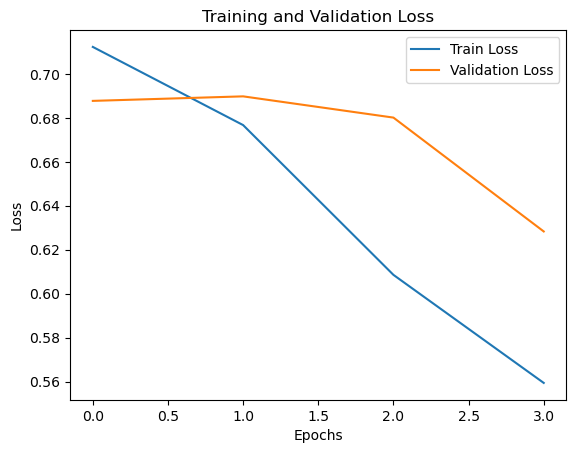

In [7]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

def tokenize_function(examples, tokenizer=tokenizer):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Convert tokenized datasets to TensorFlow datasets
train_tf_dataset = tokenized_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=8
)

test_tf_dataset = tokenized_test_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


clear_output(wait=True) # remove library warnings
history = model.fit(
    train_tf_dataset,
    validation_data=test_tf_dataset,
    epochs=4
)

# Plot training and validation losses
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Save the model you just fine-tuned and load it, and classify texts:

In [8]:
model.save_pretrained("fine-tuned-distilbert-rq-testing")
tokenizer.save_pretrained("fine-tuned-distilbert-rq-testing")
classifier = pipeline("text-classification", model="fine-tuned-distilbert-rq-testing", tokenizer="fine-tuned-distilbert-rq-testing")
clear_output(wait=True) # remove library warnings

texts = ["Annie are you OK?", "Are you OK Annie", "Be OK Annie", "You must be OK Annie", "You must be OK Annie, aren't you?",
         "Does this ever cause you any lack of confidence", "Give me five", "Open the pod bay doors HAL",
         "This is an order", "Is this an order", "Could this perhaps be an order?", "How old are you?", "Pass butter",
         "It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency?",
         "give me 5 sentences that end with the word apple", "How do I sort an array in python?",
         "Hello, give me an example of something interesting you can do.", "What assembly language is used by the GameCube",
         "Pass the butter", "Am I tall", "Are you tall", "Who's taller?",
         "write the lyrics to a rap song about some dude called phogos",
         "I have three oranges today, I ate an orange yesterday. How many oranges do I have?",
          "From what song did Red Garland quote in order to tease miles davis in 1958?"
         ]
results = classifier(texts)
label_map = {0: "question", 1: "request"}

print("### Classification with fine-tuned distilbert-base-uncased ###")
for text, result in zip(texts, results):
    label_str = label_map[int(result['label'].split('_')[-1])]
    prob = result['score']
    print(f"{text} -> {label_str} ({prob:.3f})")

### Classification with fine-tuned distilbert-base-uncased ###
Annie are you OK? -> question (0.990)
Are you OK Annie -> question (0.992)
Be OK Annie -> request (0.970)
You must be OK Annie -> question (0.720)
You must be OK Annie, aren't you? -> question (0.980)
Does this ever cause you any lack of confidence -> question (0.991)
Give me five -> request (0.976)
Open the pod bay doors HAL -> request (0.977)
This is an order -> request (0.974)
Is this an order -> question (0.991)
Could this perhaps be an order? -> question (0.986)
How old are you? -> question (0.991)
Pass butter -> request (0.977)
It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency? -> question (0.991)
give me 5 sentences that end with the word apple -> request (0.980)
How do I sort an array in python? -> question (0.992)
Hello, give me an example of something interesting you can do. -> request (0.975)
What assembly language is used by the GameCube -> question

... adjust the dataset, adding or removing examples, and retrain until satisfied.

### Zero-shot classification with fine-tuned model available on Kaggle

You can also download the model I uploaded to Kaggle (https://www.kaggle.com/models/davidgromero/fine-tuned-distilbert-rq/transformers/default/1) using the Kagglehub library: 

In [7]:
import kagglehub
kaggle_path = "davidgromero/fine-tuned-distilbert-rq/transformers/default/1"
kaggle_model = kagglehub.model_download(kaggle_path)
print(f'Model downloaded at:\n{kaggle_model}')

Model downloaded at:
C:\Users\david\.cache\kagglehub\models\davidgromero\fine-tuned-distilbert-rq\transformers\default\1


In [9]:
K_PATH = f"{kaggle_model}/fine-tuned-distilbert-rq"
classifier = pipeline("text-classification", model=K_PATH, tokenizer=K_PATH)

texts = ["Annie are you OK?", "Are you OK Annie", "Be OK Annie", "You must be OK Annie", "You must be OK Annie, aren't you?",
         "Does this ever cause you any lack of confidence", "Give me five", "Open the pod bay doors HAL",
         "This is an order", "Is this an order", "Could this perhaps be an order?", "How old are you?", "Pass butter",
         "It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency?",
         "give me 5 sentences that end with the word apple", "How do I sort an array in python?",
         "Hello, give me an example of something interesting you can do.", "What assembly language is used by the GameCube",
         "Pass the butter", "Am I tall", "Are you tall", "Who's taller?",
         "write the lyrics to a rap song about some dude called phogos",
         "I have three oranges today, I ate an orange yesterday. How many oranges do I have?",
          "From what song did Red Garland quote in order to tease miles davis in 1958?"
         ]
results = classifier(texts)
label_map = {0: "question", 1: "request"}

clear_output(wait=True) # remove library warnings
print("### Zero/shot classification with davidgromero/fine-tuned-distilbert-rq ###")
for text, result in zip(texts, results):
    label_str = label_map[int(result['label'].split('_')[-1])]
    prob = result['score']
    print(f"{text} -> {label_str} ({prob:.3f})")

### Zero/shot classification with davidgromero/fine-tuned-distilbert-rq ###
Annie are you OK? -> question (0.965)
Are you OK Annie -> question (0.969)
Be OK Annie -> request (0.977)
You must be OK Annie -> request (0.925)
You must be OK Annie, aren't you? -> question (0.954)
Does this ever cause you any lack of confidence -> question (0.968)
Give me five -> request (0.980)
Open the pod bay doors HAL -> request (0.979)
This is an order -> request (0.973)
Is this an order -> question (0.967)
Could this perhaps be an order? -> question (0.968)
How old are you? -> question (0.966)
Pass butter -> request (0.977)
It a user use an ai tex generation with custom characters for masturbate him  could be considered porn dependency? -> question (0.957)
give me 5 sentences that end with the word apple -> request (0.979)
How do I sort an array in python? -> question (0.967)
Hello, give me an example of something interesting you can do. -> request (0.979)
What assembly language is used by the GameCube